# Building a LangGraph Agent

The following example demonstrates building an agent using LangGraph. Zep is used to personalize agent responses based on information learned from prior conversations. 

The agent implements:
- persistance of new chat turns to Zep and recall of relevant Facts using the most recent messages.
- an in-memory MemorySaver to maintain agent state. We use this to add recent chat history to the agent prompt. As an alternative, you could use Zep for this. 

**IMPRTANT**: You should consider truncating MemorySaver's chat history as by default LangGraph state grows unbounded. We've included this in our example below. See the LangGraph documentation for insight.

## Install dependencies
```shell
pip install zep-cloud langchain-openai langgraph ipywidgets
```

In [1]:
import logging
import os
import sys
import uuid
from contextlib import suppress
from typing import Annotated

from dotenv import load_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict

load_dotenv()

True

In [2]:
def setup_logging():
    logger = logging.getLogger()
    logger.setLevel(logging.ERROR)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.ERROR)
    formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    return logger


logger = setup_logging()

## LangSmith integration (Optional)

If you'd like to trace your agent using LangSmith, ensure that you have a `LANGSMITH_API_KEY` set in your environment.

Then set `os.environ['LANGCHAIN_TRACING_V2'] = 'false'` to `true`.


In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "Zep LangGraph Tutorial"

## Configure Zep

Ensure that you've configured the following API key in your environment. We're using Zep's Async client here, but we could also use the non-async equivalent.

```bash
ZEP_API_KEY=
```

In [4]:
from zep_cloud import Message
from zep_cloud.client import AsyncZep

zep = AsyncZep(api_key=os.environ.get("ZEP_API_KEY"))

In [5]:
from langchain_core.messages import AIMessage, SystemMessage, trim_messages
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode

## Using Zep's Search as a Tool
These are examples of simple Tools that searches Zep for facts (from edges) or nodes.

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    first_name: str
    last_name: str
    session_id: str
    user_name: str


@tool
async def search_facts(state: State, query: str, limit: int = 5) -> list[str]:
    """Search for facts in all conversations had with a user.

    Args:
        state (State): The Agent's state.
        query (str): The search query.
        limit (int): The number of results to return. Defaults to 5.

    Returns:
        list: A list of facts that match the search query.
    """
    edges = await zep.graph.search(
        user_id=state["user_name"], text=query, limit=limit, search_scope="edges"
    )
    return [edge.fact for edge in edges]


@tool
async def search_nodes(state: State, query: str, limit: int = 5) -> list[str]:
    """Search for nodes in all conversations had with a user.

    Args:
        state (State): The Agent's state.
        query (str): The search query.
        limit (int): The number of results to return. Defaults to 5.

    Returns:
        list: A list of node summaries for nodes that match the search query.
    """
    nodes = await zep.graph.search(
        user_id=state["user_name"], text=query, limit=limit, search_scope="nodes"
    )
    return [node.summary for node in nodes]


tools = [search_facts, search_nodes]

tool_node = ToolNode(tools)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

## Chatbot Function Explanation

The chatbot uses Zep to provide context-aware responses. Here's how it works:

1. **Context Retrieval**: It retrieves relevant facts for the user's current conversation (session). Zep uses the most recent messages to determine what facts to retrieve.

2. **System Message**: It constructs a system message incorporating the facts retrieved in 1., setting the context for the AI's response.

3. **Message Persistence**: After generating a response, it asynchronously adds the user and assistant messages to Zep. New Facts are created and existing Facts updated using this new information.

4. **Messages in State**: We use LangGraph state to store the most recent messages and add these to the Agent prompt. We limit the message list to the most recent 3 messages for demonstration purposes. You may also use Zep's chat history for this purpose. 

This approach enables the chatbot to maintain context across interactions and provide personalized responses based on the user's history and preferences stored in Zep.

In [28]:
async def chatbot(state: State):
    memory = await zep.memory.get(state["session_id"])

    system_message = SystemMessage(
        content=f"""You are a compassionate mental health bot and caregiver. Review information about the user and their prior conversation below and respond accordingly.
        Keep responses empathetic and supportive. And remember, always prioritize the user's well-being and mental health.

        {memory.context}"""
    )

    messages = [system_message] + state["messages"]

    response = await llm.ainvoke(messages)

    # Add the new chat turn to the Zep graph
    messages_to_save = [
        Message(
            role_type="user",
            role=state["first_name"] + " " + state["last_name"],
            content=state["messages"][-1].content,
        ),
        Message(role_type="assistant", content=response.content),
    ]

    await zep.memory.add(
        session_id=state["session_id"],
        messages=messages_to_save,
    )

    # Truncate the chat history to keep the state from growing unbounded
    # In this example, we going to keep the state small for demonstration purposes
    # We'll use Zep's Facts to maintain conversation context
    state["messages"] = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=len,
        max_tokens=3,
        start_on="human",
        end_on=("human", "tool"),
        include_system=True,
    )

    logger.info(f"Messages in state: {state['messages']}")

    return {"messages": [response]}

## Setting up the Agent

This section sets up the Agent's LangGraph graph:

1. **Graph Structure**: It defines a graph with nodes for the agent (chatbot) and tools, connected in a loop.

2. **Conditional Logic**: The `should_continue` function determines whether to end the graph execution or continue to the tools node based on the presence of tool calls.

3. **Memory Management**: It uses a MemorySaver to maintain conversation state across turns. This is in addition to using Zep for facts.

In [29]:
graph_builder = StateGraph(State)

memory = MemorySaver()


# Define the function that determines whether to continue or not
async def should_continue(state, config):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


graph_builder.add_node("agent", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "agent")

graph_builder.add_conditional_edges(
    "agent", should_continue, {"continue": "tools", "end": END}
)
graph_builder.add_edge("tools", "agent")


graph = graph_builder.compile(checkpointer=memory)

Our LangGraph agent graph is illustrated below.

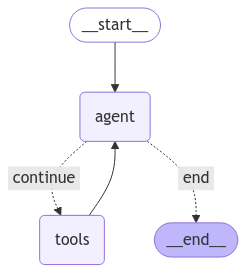

In [30]:
with suppress(Exception):
    display(Image(graph.get_graph().draw_mermaid_png()))

## Running the Agent

We generate a unique user name and thread id (session id) and add these to Zep, associating the Session with the new User.

In [31]:
first_name = "Daniel"
last_name = "Chalef"
user_name = first_name + uuid.uuid4().hex[:4]
thread_id = uuid.uuid4().hex

await zep.user.add(user_id=user_name, first_name=first_name, last_name=last_name)
await zep.memory.add_session(session_id=thread_id, user_id=user_name)


def extract_messages(result):
    output = ""
    for message in result["messages"]:
        if isinstance(message, AIMessage):
            role = "assistant"
        else:
            role = result["user_name"]
        output += f"{role}: {message.content}\n"
    return output.strip()


async def graph_invoke(
    message: str,
    first_name: str,
    last_name: str,
    thread_id: str,
    ai_response_only: bool = True,
):
    r = await graph.ainvoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": message,
                }
            ],
            "first_name": first_name,
            "last_name": last_name,
            "session_id": thread_id,
        },
        config={"configurable": {"thread_id": thread_id}},
    )

    if ai_response_only:
        return r["messages"][-1].content
    else:
        return extract_messages(r)

In [32]:
r = await graph_invoke(
    "Hi there?",
    first_name,
    last_name,
    thread_id,
)

print(r)

Hello! How are you feeling today? I'm here to listen and support you.


In [33]:
r = await graph_invoke(
    "I'm fine. But have been a bit stressful lately. Mostly work related. But also my dog.",
    first_name,
    last_name,
    thread_id,
)

print(r)

I'm sorry to hear that you've been feeling stressed, especially with work and your dog. It can be tough when multiple things weigh on us. Would you like to share more about what's been causing the stress at work or any specific concerns you have about your dog? I'm here to help.


In [34]:
r = await graph_invoke(
    "She's sick. I'm worried about her.",
    first_name,
    last_name,
    thread_id,
)

print(r)

It's completely understandable to feel worried when a beloved pet is sick. Our pets are like family, and their health can deeply affect us. What symptoms is she showing, and have you been able to take her to the vet? I'm here to support you through this.


## Wait a few seconds to allow Zep to ingest the new messages

Zep takes a few seconds to ingest messages and build the user knowledge graph. The last few messages in the chat thread being passed to the agent should ensure the agent remains grounded in the recent conversation.

## Viewing The Context Value

In [42]:
memory = await zep.memory.get(session_id=thread_id)

print(memory.context)


FACTS and ENTITIES represent relevant context to the current conversation.

# These are the most relevant facts and their valid date ranges
# format: FACT (Date range: from - to)
<FACTS>
  - Daniel99db is worried about his sick dog. (2025-01-24 02:11:54 - present)
  - Daniel Chalef is worried about his sick dog. (2025-01-24 02:11:54 - present)
  - The assistant asks how the user is feeling. (2025-01-24 02:11:51 - present)
  - Daniel99db has been a bit stressful lately due to his dog. (2025-01-24 02:11:53 - present)
  - Daniel99db has been a bit stressful lately due to work. (2025-01-24 02:11:53 - present)
  - Daniel99db is a user. (2025-01-24 02:11:51 - present)
  - user has the id of Daniel99db (2025-01-24 02:11:50 - present)
  - user has the name of Daniel Chalef (2025-01-24 02:11:50 - present)
</FACTS>

# These are the most relevant entities
# ENTITY_NAME: entity summary
<ENTITIES>
  - worried: Daniel Chalef (Daniel99db) is feeling stressed lately, primarily due to work-related iss

In [43]:
r = await graph_invoke(
    "She ate my shoes which were expensive.",
    first_name,
    last_name,
    thread_id,
)

print(r)

That sounds really frustrating, especially when you care so much about your belongings and your dog’s health. It’s tough when pets get into things they shouldn’t, and it can add to your stress. How are you feeling about that situation? Are you able to focus on her health despite the shoe incident?


Let's now test whether the Agent is correctly grounded with facts from the prior conversation.

In [44]:
r = await graph_invoke(
    "What are we talking about?",
    first_name,
    last_name,
    thread_id,
)

print(r)

We were discussing your concerns about your dog being sick and the situation with her eating your expensive shoes. It sounds like you’re dealing with a lot right now, and I want to make sure we’re addressing what’s on your mind. If there’s something else you’d like to talk about or if you want to share more about your dog, I’m here to listen.


Let's go even further back to determine whether context is kept by referencing a user message that is not currently in the Agent State. Zep will retrieve Facts related to the user's job.

In [45]:
r = await graph_invoke(
    "What have I said about my job?",
    first_name,
    last_name,
    thread_id,
)

print(r)

You've mentioned that you've been feeling a bit stressed lately, primarily due to work-related issues. If you'd like to share more about what's been going on at work or how it's affecting you, I'm here to listen and support you.
